# K-Means Clustering

K-means is an unsupervised classification algorithm. Its goal is to partition a set of n observations into k clusters, where each observation belongs to the cluster with the nearest mean.

K-means steps: 
* Initialize k cluster centroids at random locations within the feature space.
* Assign each observation to the cluster with the nearest centroid (by calculating the Euclidean distance between the observation and each centroid).
* Update the centroid of each cluster to the mean of all the observations assigned to that cluster.
* Repeat steps 2 and 3 until the assignment of observations to clusters no longer changes or a stopping criteria is met.

K-means assumes that all clusters have similar number of points and equal variances.

<img src="images/k_means.gif" width="40%">

### Read data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import random

np.random.seed(50)
sns.set_style('darkgrid')
palette1 = {1: "#22BF9B", 2: "#10E8EC", 3: "#9265F5", 4: "#1665D2", 5: "#05A5CB"}
palette2 = {1: "#05A5CB", 2: "#22BF9B", 3: "#10E8EC", 4: "#1665D2", 5: "#9265F5"}

In [17]:
X, y = make_blobs(n_samples = 500, centers = 5, cluster_std = 1.5, n_features = 2)
X, y = pd.DataFrame(X).rename(columns={0:'feature1', 1: 'feature2'}), pd.Series(y+1).rename('label')
pd.concat([X, y], axis=1).head()

,feature1,feature2,label
0,-0.446604,-5.448554,1
1,-0.453598,6.234575,4
2,-3.818534,-0.153022,2
3,-0.332617,-4.402878,1
4,1.171902,5.303620,4


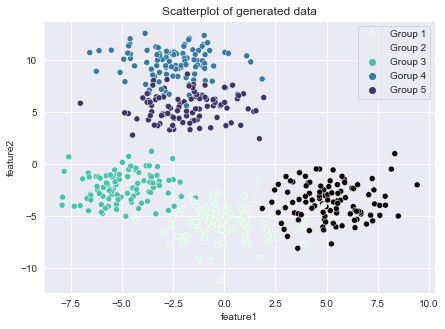

In [18]:
plt.figure(figsize=(7, 5))
plt.title('Scatterplot of generated data')
sns.scatterplot(data=X, x='feature1', y='feature2', hue=y, palette='mako_r')
plt.legend(labels=['Group 1', 'Group 2', 'Group 3', 'Gorup 4', 'Group 5'])
plt.show()

### K-Means Clustering

In [19]:
# Choose a K
K = 5

# Initialize k random clusters
x_coord = np.random.randint(-10, 10, K)
y_coord = np.random.randint(-10, 10, K)
centroids = pd.concat([pd.Series(x_coord).rename('x'), pd.Series(y_coord).rename('y')], axis=1)
centroids.set_index(centroids.index + 1, inplace=True) # Set the index of centroids to be 1 to 5

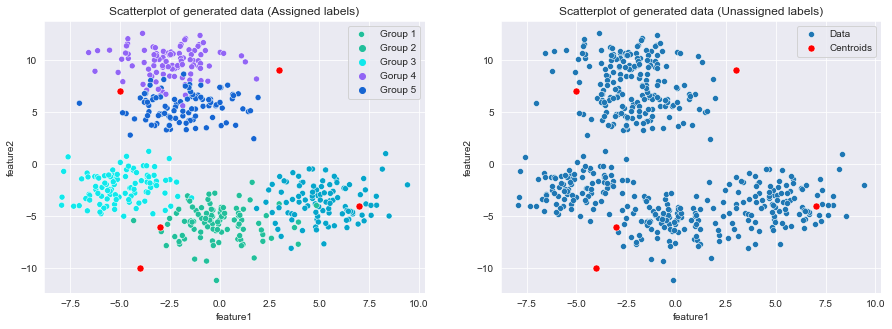

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data=X, x='feature1', y='feature2', hue=y, palette=palette1)
sns.scatterplot(ax=axes[0], x=centroids['x'], y=centroids['y'], color='r', s=50)
axes[0].set_title('Scatterplot of generated data (Assigned labels)')
sns.scatterplot(ax=axes[1], data=X, x='feature1', y='feature2')
sns.scatterplot(ax=axes[1], x=centroids['x'], y=centroids['y'], color='r', s=50)
axes[1].set_title('Scatterplot of generated data (Unassigned labels)')

axes[0].legend(labels=['Group 1', 'Group 2', 'Group 3', 'Gorup 4', 'Group 5'])
axes[1].legend(labels=['Data', 'Centroids'])
plt.show()

In [21]:
# Calculates the Euclidean Distance between two points
def calc_euclidean_distance(pointA, pointB): return np.sqrt((pointB[0] - pointA[0])**2 + (pointB[1] - pointA[1])**2)

# Assign a cluster to each data point (based on euclidean distance)
def assign_to_cluster(X, centroids):
    for i in X.index:
        point = X.iloc[i][['feature1', 'feature2']]

        min_dist = np.inf
        for label, centroid in enumerate(centroids.values): 
            distance = calc_euclidean_distance(point, centroid)

            if distance < min_dist:
                min_dist = distance
                X.loc[i, 'label'] = label+1
                
    return X

# Move the cluster to the centroid of the data points assigned to it
def update_centroids(X, centroids):
    for k in range(1, K+1):
        N = len(X[X['label'] == k])
        new_x = X[X['label'] == k]['feature1'].sum() / N
        new_y = X[X['label'] == k]['feature2'].sum() / N

        centroids.loc[k, 'x'] = new_x
        centroids.loc[k, 'y'] = new_y
    return centroids

# Plot the centroids with the correctly grouped data side by side with the centroids with the predictedly grouped data
def plot_kmeans(X, centroids):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(ax=axes[0], data=X, x='feature1', y='feature2', hue=y, palette=palette1)
    sns.scatterplot(ax=axes[0], x=centroids['x'], y=centroids['y'], color='r', s=50, label='centroids')
    axes[0].set_title('Scatterplot of generated data (True labels)')

    sns.scatterplot(ax=axes[1], data=X, x='feature1', y='feature2', hue='label', palette=palette2)
    sns.scatterplot(ax=axes[1], x=centroids['x'], y=centroids['y'], color='r', s=50, label='centroids')
    axes[1].set_title('Scatterplot of generated data (Predicted labels)')

    axes[0].legend()

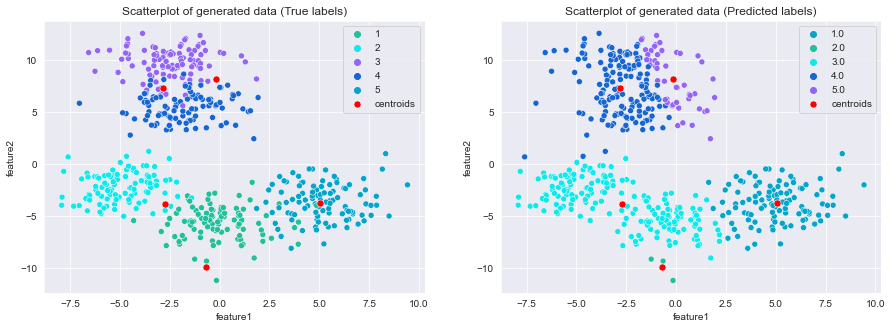

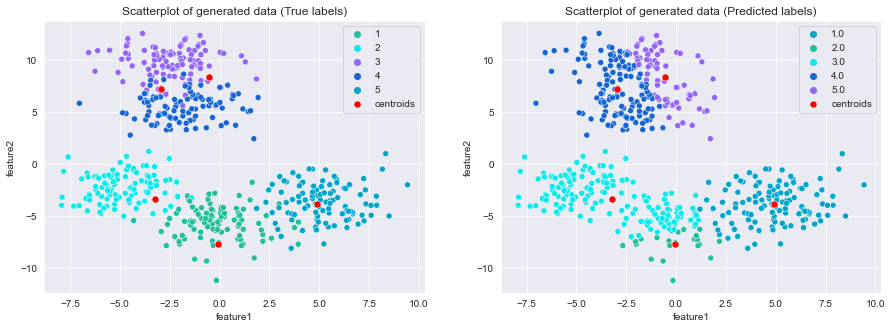

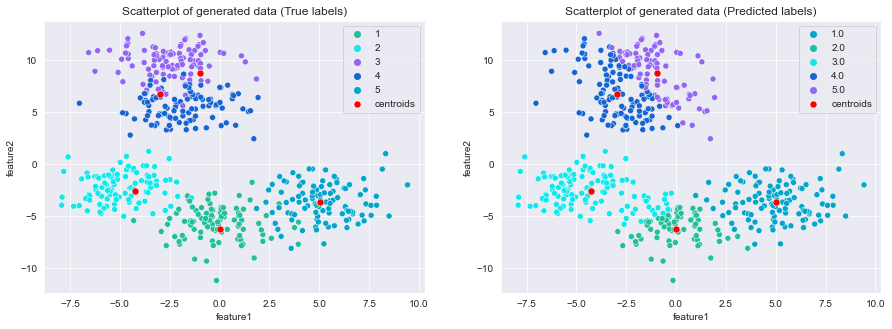

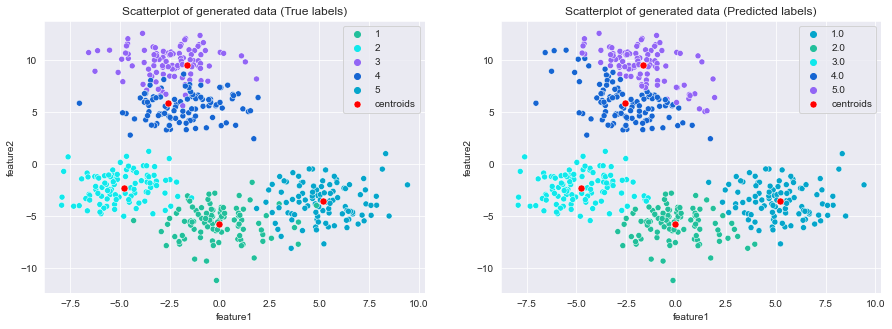

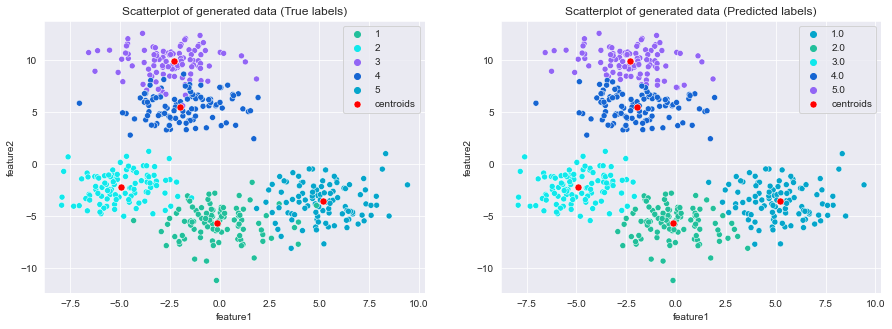

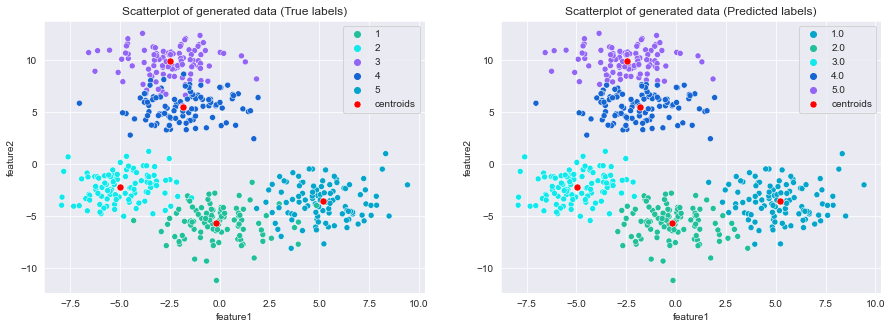

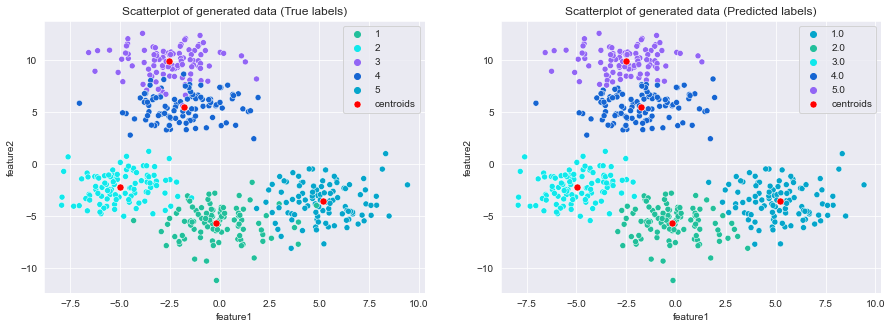

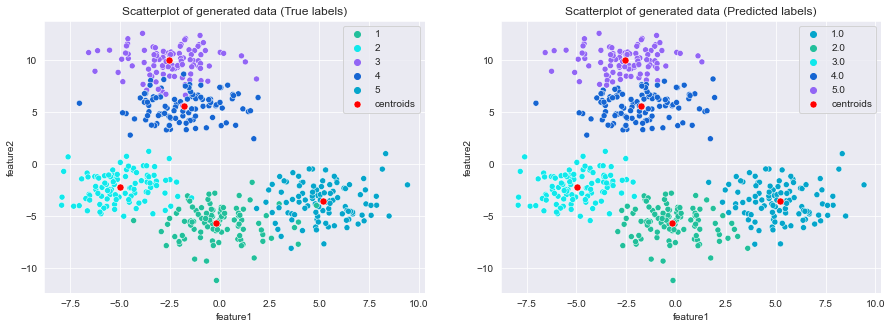

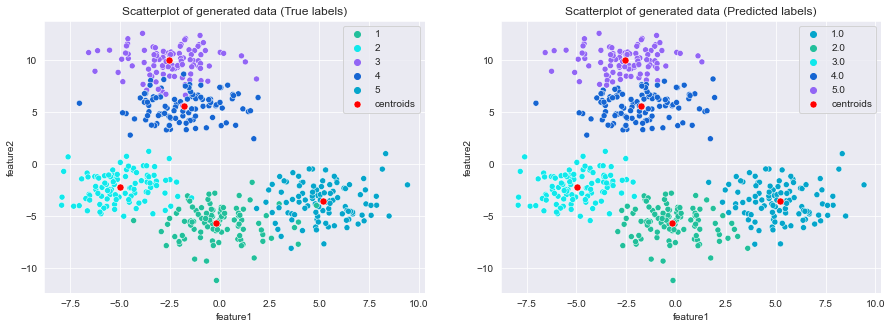

In [22]:
prev_centroids = 0
while centroids.equals(prev_centroids) == False:
    
    # Save the current centroids (to check if they are still being updated)
    prev_centroids = centroids.copy()
    
    # Assign all datapoints to their nearest cluster
    X = assign_to_cluster(X, centroids)
    
    # Update the location of the centroids based on their assigned datapoints
    centroids = update_centroids(X, centroids)
    
    # Plot the progress
    plot_kmeans(X, centroids)

### How to determine K

The data used in this notebook was synthetically generated to fit exactly 5 clusters, but that is not usually known when using K-Means clustering. Thus, we need to follow a method to determine the number of clusters that better fit the data we are given.<br>

The most common methods are the following:
* Elbow method
* Silhouette method

#### Elbow method

The elbow method is a very naive approach to decide the optimal k. It is performed by calculating the Within-Cluster-Sum of Squared Errors (WSS) for different values of k (also called inertia). A good model is one with low inertia and a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.


In [23]:
WSS_list = []
for k in range(1,25):
    
    # Initialize k random clusters
    x_coord = np.random.randint(-10, 10, k)
    y_coord = np.random.randint(-10, 10, k)
    centroids = pd.concat([pd.Series(x_coord).rename('x'), pd.Series(y_coord).rename('y')], axis=1)
    centroids.set_index(centroids.index + 1, inplace=True) # Set the index of centroids to be 1 to 5

    # Optimize the location of the clusters
    prev_centroids = 0
    while centroids.equals(prev_centroids) == False:

        # Save the current centroids (to check if they are still being updated)
        prev_centroids = centroids.copy()

        # Assign all datapoints to their nearest cluster
        X = assign_to_cluster(X, centroids)

        # Update the location of the centroids based on their assigned datapoints
        centroids = update_centroids(X, centroids)

        # Plot the progress
        #plot_kmeans(X, centroids)
        
    # Calculate the WSS for the specific k
    WSS = 0
    for idx in centroids.index:
        for point in X[X['label'] == idx][['feature1', 'feature2']].values:
            distance = calc_euclidean_distance(point, centroids.loc[idx])
            WSS += distance**2
    WSS_list.append(WSS)

C:\Users\alexx\AppData\Local\Temp/ipykernel_7484/3403772284.py:23: RuntimeWarning: invalid value encountered in double_scalars
  new_x = X[X['label'] == k]['feature1'].sum() / N
C:\Users\alexx\AppData\Local\Temp/ipykernel_7484/3403772284.py:24: RuntimeWarning: invalid value encountered in double_scalars
  new_y = X[X['label'] == k]['feature2'].sum() / N


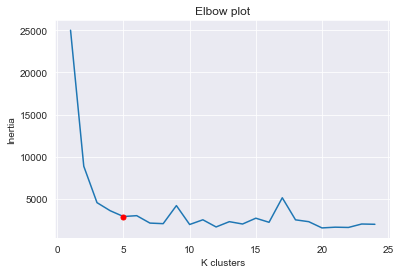

In [24]:
plt.title('Elbow plot')
sns.lineplot(x=list(range(1,25)), y=WSS_list)
plt.plot(5, WSS_list[4], color='red', marker="o", markersize=5)
plt.ylabel('Inertia')
plt.xlabel('K clusters')
plt.show()

Based on this Elbow plot, the optimal k is 5. <br>

#### Silhouette method

For n_clusters = 2 The average silhouette_score is : 0.5918306362796377
For n_clusters = 3 The average silhouette_score is : 0.4406085529084816
For n_clusters = 4 The average silhouette_score is : 0.44118299849799303
For n_clusters = 5 The average silhouette_score is : 0.46292096163531915
For n_clusters = 6 The average silhouette_score is : 0.4489608738498959
For n_clusters = 7 The average silhouette_score is : 0.3790880767795241
For n_clusters = 8 The average silhouette_score is : 0.3470611539870515
For n_clusters = 9 The average silhouette_score is : 0.3416007249887093


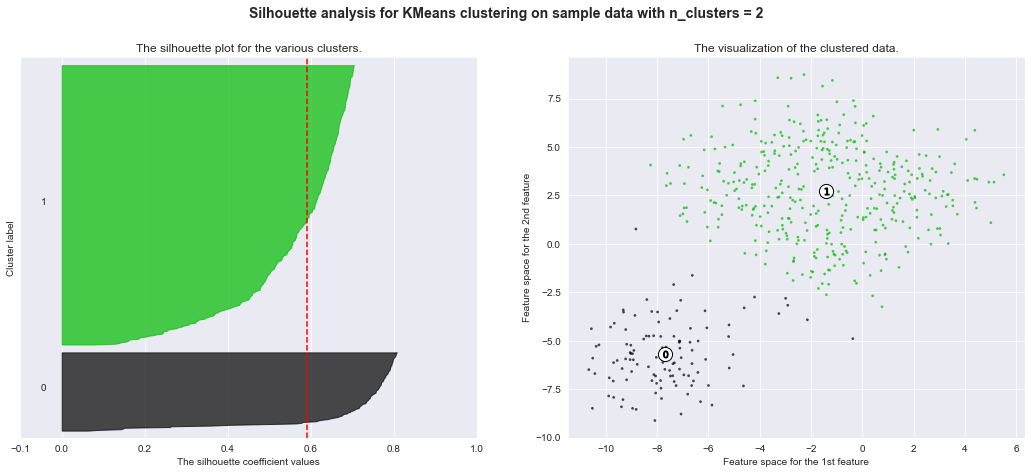

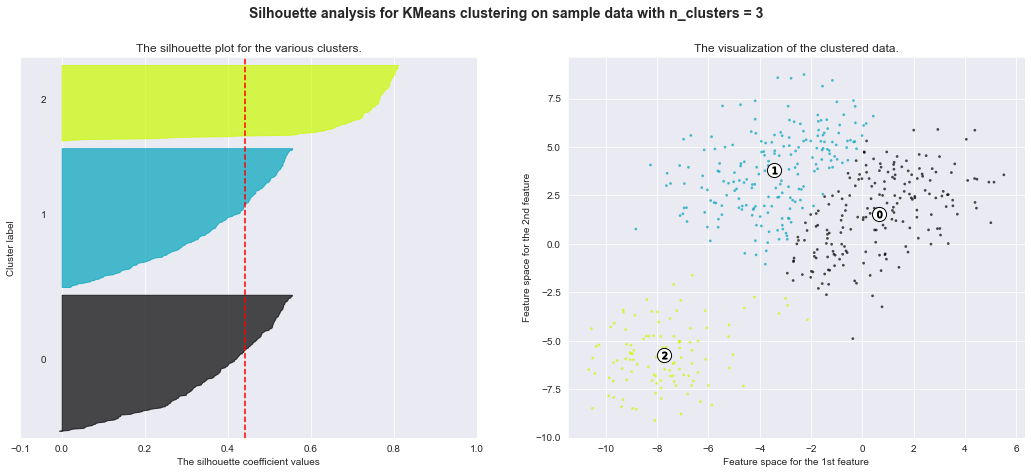

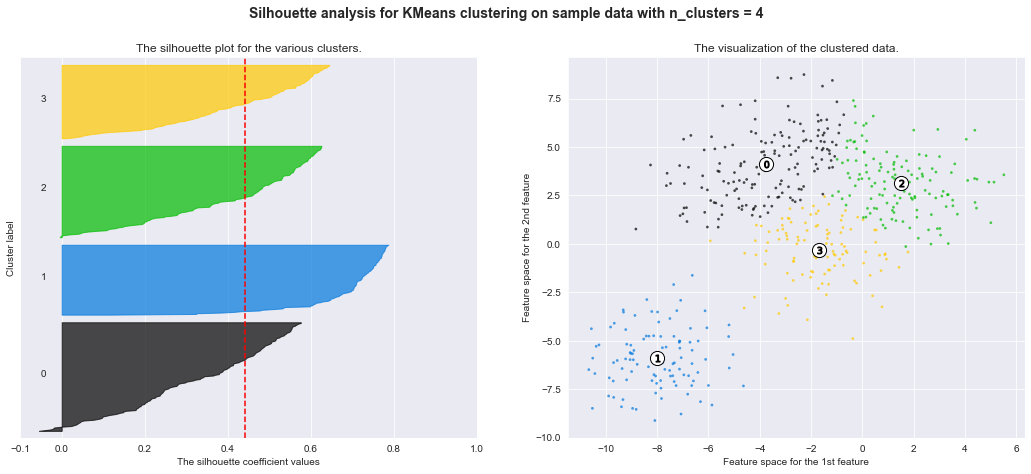

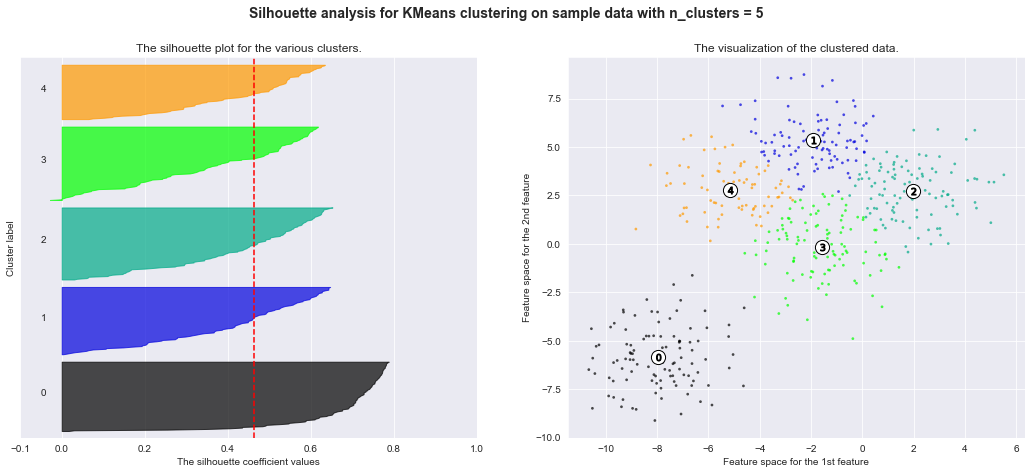

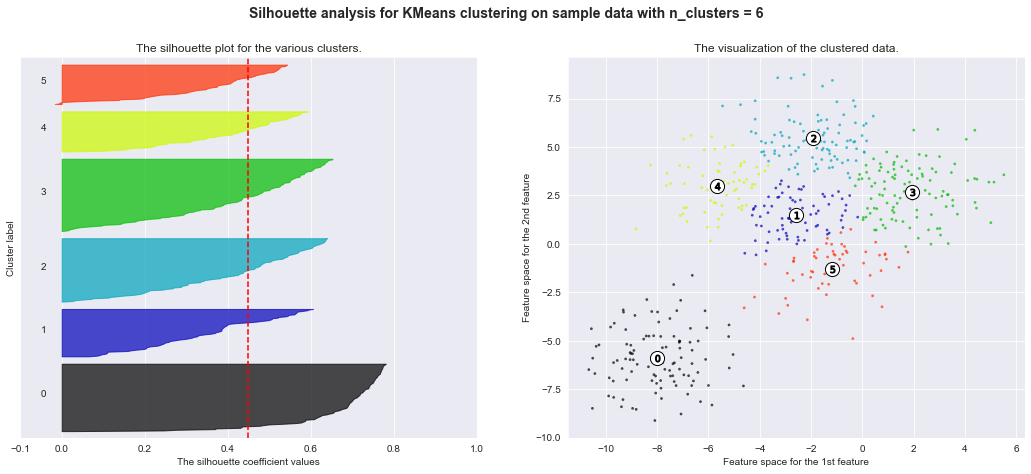

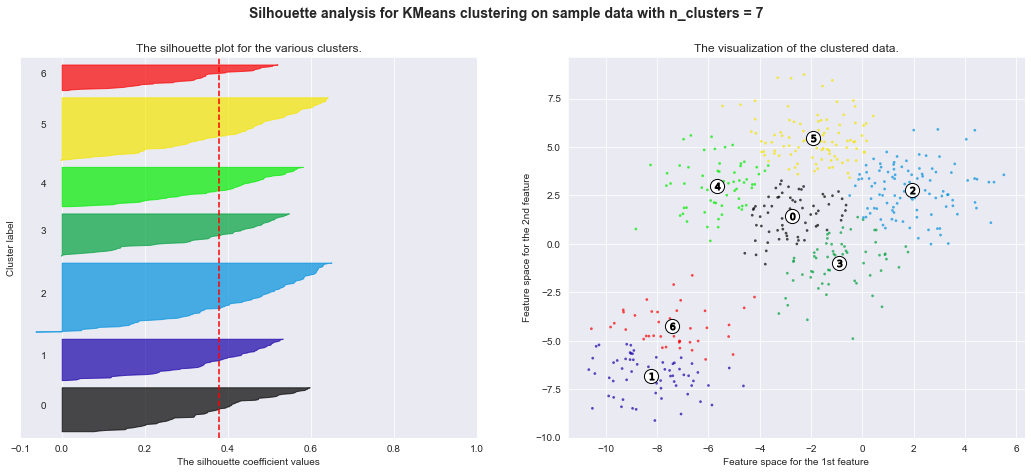

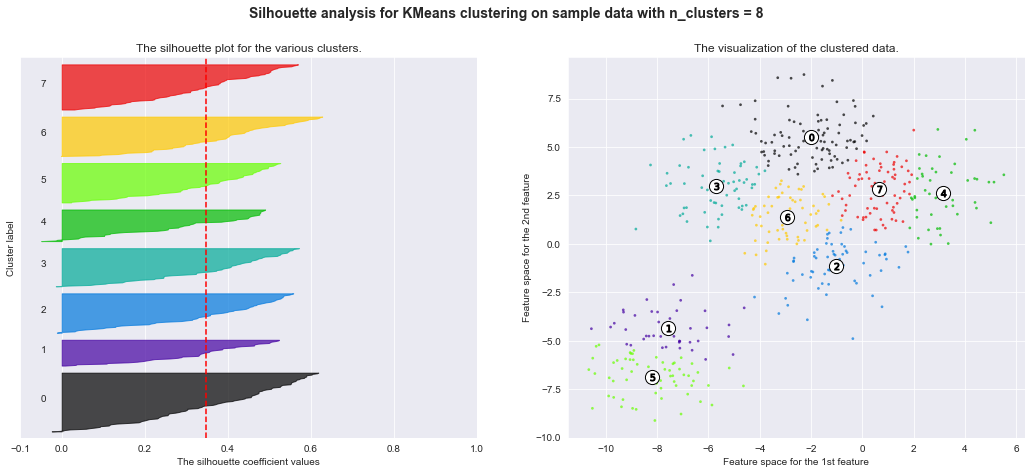

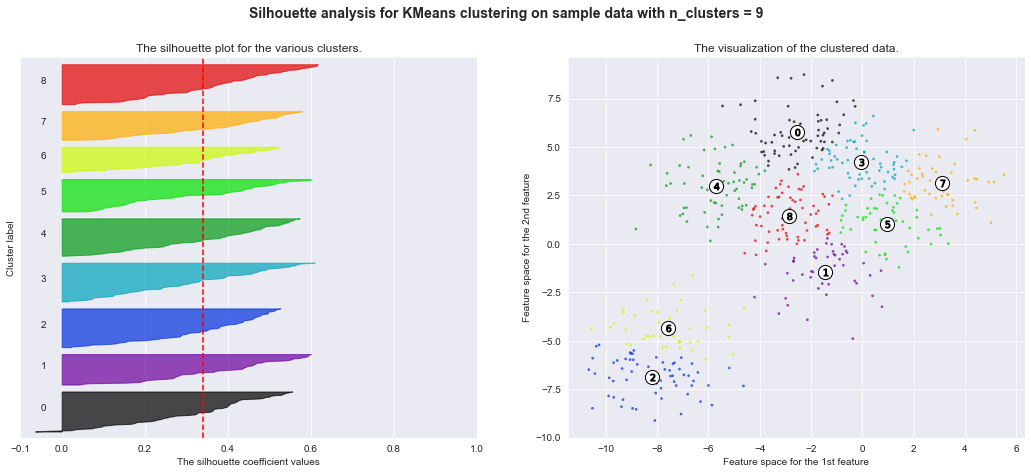

In [26]:
X, y = make_blobs(n_samples = 500, centers = 5, cluster_std = 1.5, n_features = 2)
X, y = pd.DataFrame(X).rename(columns={0:'feature1', 1: 'feature2'}), pd.Series(y+1).rename('label')

for k in range(2, 10):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    axes[0].set_xlim([-0.1, 1])
    axes[0].set_ylim([0, len(X) + (k + 1) * 10]) # Inserts blank space between silhouette plots of each cluster

    clusterer = KMeans(n_clusters=k)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        axes[0].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=cm.nipy_spectral(float(i) / k), edgecolor=cm.nipy_spectral(float(i) / k), alpha=0.7)

        axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))  # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10 # Compute the new y_lower for next plot

    axes[0].set_title("The silhouette plot for the various clusters.")
    axes[0].set_xlabel("The silhouette coefficient values")
    axes[0].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--")

    axes[0].set_yticks([])  # Clear the yaxis labels / ticks
    axes[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    axes[1].scatter(X.loc[:, 'feature1'], X.loc[:, 'feature2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    axes[1].scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(centers):
        axes[1].scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    axes[1].set_title("The visualization of the clustered data.")
    axes[1].set_xlabel("Feature space for the 1st feature")
    axes[1].set_ylabel("Feature space for the 2nd feature")

    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % k, fontsize=14, fontweight="bold",)

plt.show()

The following conditions should be checked to pick the right ‘K’ using the Silhouette plots:

* All the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line). 

All clusters follow this condition.<br>

* There should not be wide fluctuations in the size of the clusters (the width of the clusters represents the number of data points). 

For **K = 2**, the green cluster has more than twice the width of the black cluster. <br>
This green cluster gets broken down into 2 sub-clusters for **K = 3** but they are still twice the size  of the yellow cluster.<br>
On **K = 4**, the black cluster shows a higher number of data points than any other cluster. <br>
Finally, the **K = 5** Silhouette plot shows a similar sized group of clusters!